#### EDA - Text Classification - Ham vs Spam Filter

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [13]:
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
print(f"\nDataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print('\n Last 5 rows of the dataset:')
print(df.tail())


Dataset shape: (5572, 5)
Number of rows: 5572
Number of columns: 5

First 5 rows of the dataset:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

 Last 5 rows of the dataset:
        v1                                                 v2 Unnamed: 2  \
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...an

In [15]:
# Column Info

print("\nColumn Information:")
print(df.columns.to_list())

print("\nDatatype Info:")
print(df.dtypes)

print("\n Dataset Info:")
print(df.info())


Column Information:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Datatype Info:
v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None



Missing values by column:
       Column  Missing_Count  Missing_Percent
0          v1              0         0.000000
1          v2              0         0.000000
2  Unnamed: 2           5522        99.102656
3  Unnamed: 3           5560        99.784637
4  Unnamed: 4           5566        99.892319


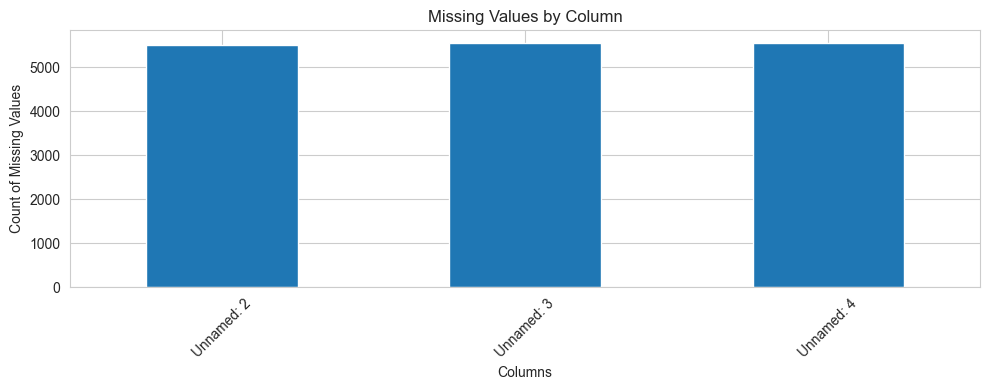

In [16]:
# Missing Values

missing = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percent': missing_percent.values
})

print("\nMissing values by column:")
print(missing_df)

# Visualize missing values
if missing.sum() > 0:
    plt.figure(figsize=(10, 4))
    missing[missing > 0].plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Count of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values found!")

In [17]:
# Renaming columns

if 'v1' in df.columns and 'v2' in df.columns:
    # Keep only the first two columns
    df = df[['v1', 'v2']]
    df.columns = ['label', 'message']
    print("\n✓ Columns renamed to 'label' and 'message'")
else:
    print("\n⚠ Column names don't match expected format. Current columns:")
    print(df.columns.tolist())

print("\nCleaned dataset:")
print(df.head())


✓ Columns renamed to 'label' and 'message'

Cleaned dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...



Class counts:
label
ham     4825
spam     747
Name: count, dtype: int64

Class percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Summary:
       Count  Percentage
label                   
ham     4825   86.593683
spam     747   13.406317


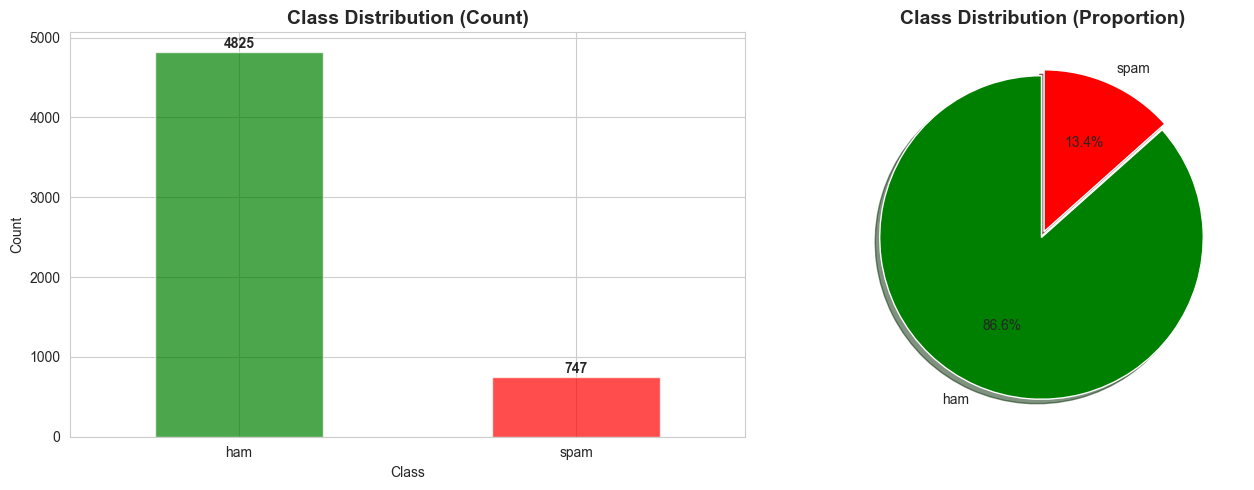

Class Imbalance Ratio: 6.46:1
Dataset is imbalanced - Need to consider this when training models


In [27]:
# Class Distribution

class_counts = df['label'].value_counts()
print("\nClass counts:")
print(class_counts)

# Percentage by class
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nClass percentages:")
print(class_percent)

# Create summary table
summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percent
})
print("\nSummary:")
print(summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['green', 'red']
explode = (0.02, 0.02)
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Checking for class imbalance
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print("Dataset is imbalanced - Need to consider this when training models")
else:
    print("Dataset is relatively balanced")

In [29]:
# Sample Message inspection from each class

print("\nSample ham message:")
ham_samples = df[df['label'] == 'ham']['message'].sample(3, random_state=42)
for i, msg in enumerate(ham_samples, 1):
    print(f"\n{i}. {msg}")

print("\nSample spam message:")
spam_samples = df[df['label'] == 'spam']['message'].sample(3, random_state=42)
for i, msg in enumerate(spam_samples, 1):
    print(f"\n{i}. {msg}")



Sample ham message:

1. I am late,so call you tomorrow morning.take care sweet dreams....u and me...ummifying...bye.

2. U r too much close to my heart. If u go away i will be shattered. Plz stay with me.

3. Wait  &lt;#&gt;  min..

Sample spam message:

1. Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804

2. This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate 

3. Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just å£1.50 per wk 2 opt out send STOP 08452810071 16



Overall message length statistics:
count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64

Message length by class:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


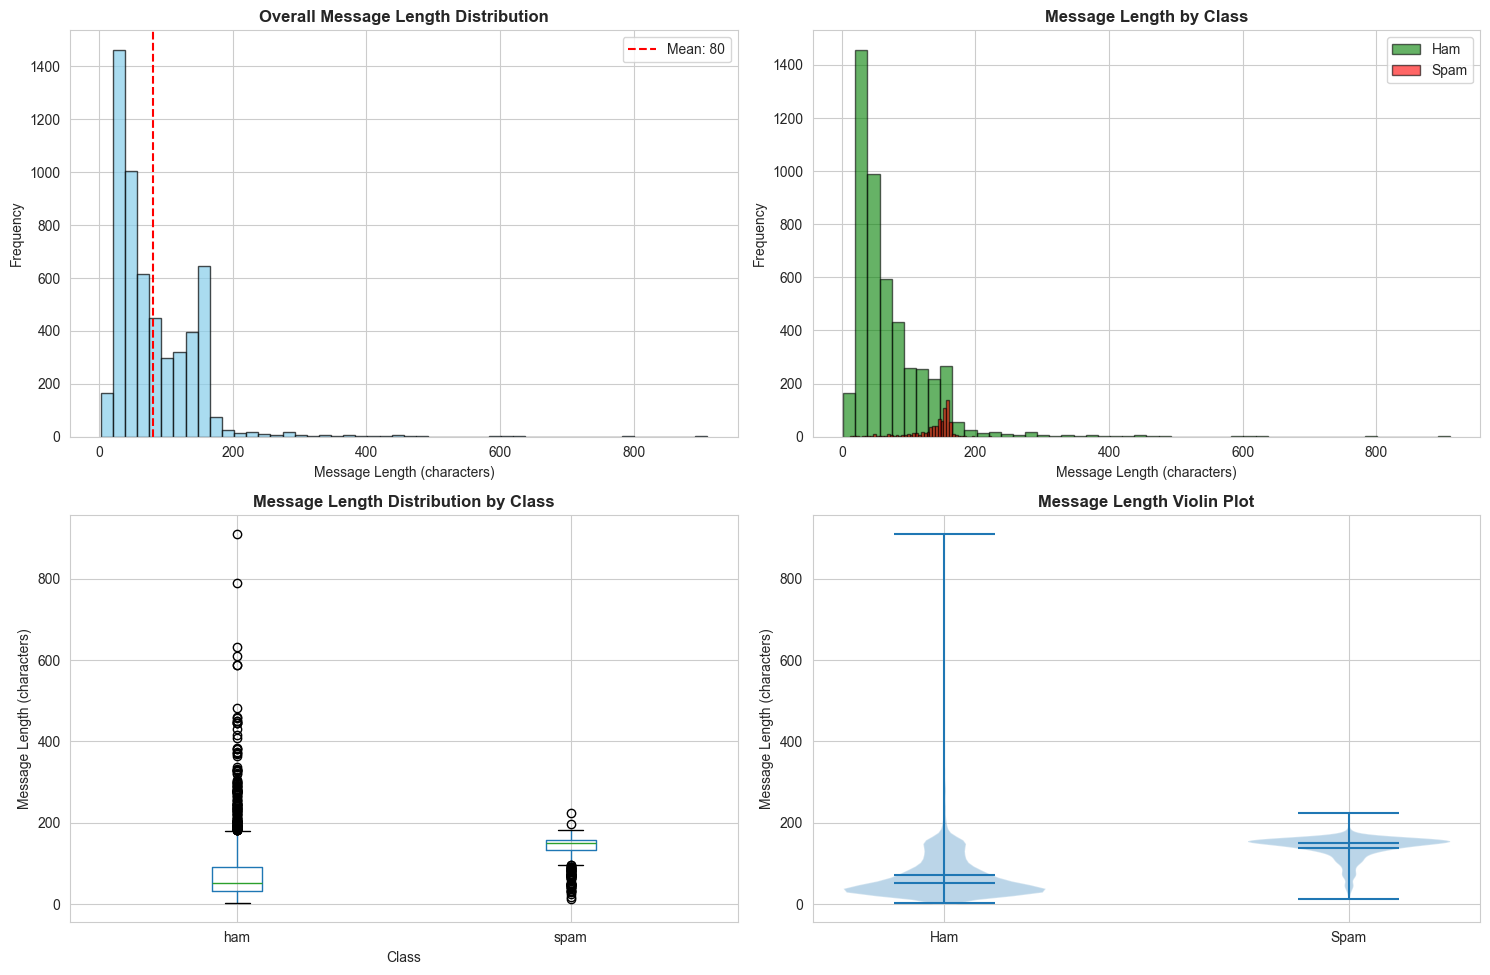


Statistical comparison:
Average Ham message length: 71.02 characters
Average Spam message length: 138.87 characters
Difference: 67.84 characters


In [31]:
# Message Length Analysis

df['message_length'] = df['message'].apply(len)

print("\nOverall message length statistics:")
print(df['message_length'].describe())

print("\nMessage length by class:")
print(df.groupby('label')['message_length'].describe())


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0, 0].hist(df['message_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Overall Message Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Message Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['message_length'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["message_length"].mean():.0f}')
axes[0, 0].legend()

# Distribution by class
ham_length = df[df['label'] == 'ham']['message_length']
spam_length = df[df['label'] == 'spam']['message_length']

axes[0, 1].hist(ham_length, bins=50, alpha=0.6, label='Ham', color='green', edgecolor='black')
axes[0, 1].hist(spam_length, bins=50, alpha=0.6, label='Spam', color='red', edgecolor='black')
axes[0, 1].set_title('Message Length by Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Message Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Box plot by class
df.boxplot(column='message_length', by='label', ax=axes[1, 0])
axes[1, 0].set_title('Message Length Distribution by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Message Length (characters)')
plt.suptitle('')  # Remove automatic title

# Violin plot
spam_data = df[df['label'] == 'spam']['message_length']
ham_data = df[df['label'] == 'ham']['message_length']
axes[1, 1].violinplot([ham_data, spam_data], positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 1].set_title('Message Length Violin Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([1, 2])
axes[1, 1].set_xticklabels(['Ham', 'Spam'])
axes[1, 1].set_ylabel('Message Length (characters)')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical comparison:")
print(f"Average Ham message length: {ham_length.mean():.2f} characters")
print(f"Average Spam message length: {spam_length.mean():.2f} characters")
print(f"Difference: {abs(ham_length.mean() - spam_length.mean()):.2f} characters")


Overall word count statistics:
count    5572.000000
mean       15.494436
std        11.329427
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: word_count, dtype: float64

Word count by class:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.200622  11.424511  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.851406   5.811898  2.0  22.0  25.0  28.0   35.0


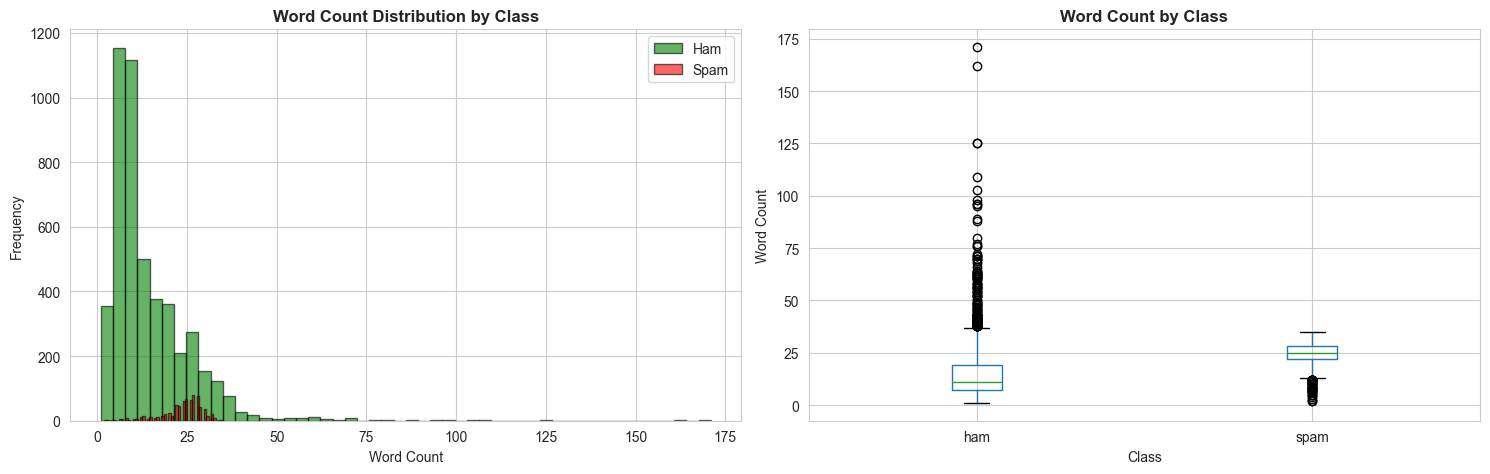


Average Ham word count: 14.20 words
Average Spam word count: 23.85 words


In [32]:
# Word Count

df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

print("\nOverall word count statistics:")
print(df['word_count'].describe())

print("\nWord count by class:")
print(df.groupby('label')['word_count'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution by class
ham_words = df[df['label'] == 'ham']['word_count']
spam_words = df[df['label'] == 'spam']['word_count']

axes[0].hist(ham_words, bins=50, alpha=0.6, label='Ham', color='green', edgecolor='black')
axes[0].hist(spam_words, bins=50, alpha=0.6, label='Spam', color='red', edgecolor='black')
axes[0].set_title('Word Count Distribution by Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
df.boxplot(column='word_count', by='label', ax=axes[1])
axes[1].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Word Count')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nAverage Ham word count: {ham_words.mean():.2f} words")
print(f"Average Spam word count: {spam_words.mean():.2f} words")


Average word length by class:
        count      mean       std       min       25%       50%    75%  \
label                                                                    
ham    4825.0  4.177574  1.133530  1.500000  3.600000  4.000000  4.500   
spam    747.0  4.992839  1.005943  3.333333  4.423077  4.884615  5.375   

             max  
label             
ham    49.000000  
spam   17.333333  


<Figure size 1000x600 with 0 Axes>

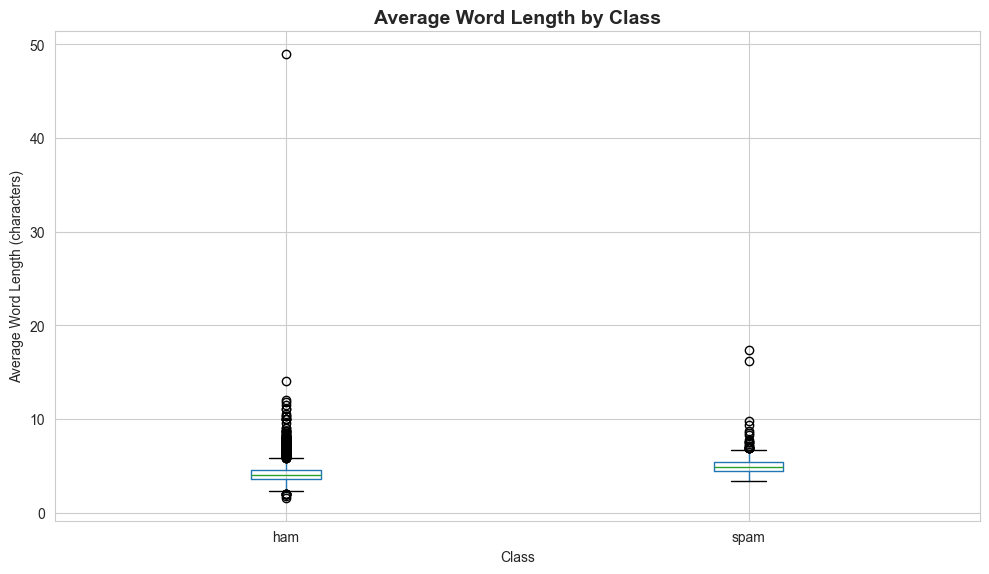

In [33]:
# Average word length

df['avg_word_length'] = df['message'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

print("\nAverage word length by class:")
print(df.groupby('label')['avg_word_length'].describe())

# Visualize
plt.figure(figsize=(10, 6))
df.boxplot(column='avg_word_length', by='label')
plt.title('Average Word Length by Class', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Class')
plt.ylabel('Average Word Length (characters)')
plt.tight_layout()
plt.show()

In [36]:
# Common Words

def get_common_words(messages, n=20):
    words = []
    for msg in messages:
        words.extend(str(msg).lower().split())
    return Counter(words).most_common(n)

# Overall most common words
print("\nTop 20 most common words (overall):")
all_common = get_common_words(df['message'])
for word, count in all_common:
    print(f"{word:15} : {count:5} times")

print("\n")
print("\nTop 20 most common words in HAM messages:")
ham_common = get_common_words(df[df['label'] == 'ham']['message'])
for word, count in ham_common:
    print(f"{word:15} : {count:5} times")

print("\n")
print("\nTop 20 most common words in SPAM messages:")

spam_common = get_common_words(df[df['label'] == 'spam']['message'])
for word, count in spam_common:
    print(f"{word:15} : {count:5} times")


Top 20 most common words (overall):
to              :  2226 times
i               :  2208 times
you             :  1917 times
a               :  1419 times
the             :  1317 times
u               :   991 times
and             :   967 times
is              :   862 times
in              :   855 times
my              :   751 times
for             :   697 times
your            :   676 times
of              :   613 times
me              :   605 times
have            :   568 times
call            :   557 times
on              :   520 times
are             :   485 times
that            :   468 times
it              :   465 times



Top 20 most common words in HAM messages:
i               :  2172 times
you             :  1665 times
to              :  1544 times
the             :  1113 times
a               :  1046 times
u               :   874 times
and             :   845 times
in              :   786 times
my              :   741 times
is              :   710 times
me              : 